<a href="https://colab.research.google.com/github/gadm21/satellite-imagery-analysis/blob/main/supervised%20learning/Supervised_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BUILDING A MODEL TO PREDICT THE URBAN AREAS OF A SATELLITE IMAGE...



---

---





# Import

In [90]:
import numpy as np
from sklearn import cluster 
from osgeo import gdal, gdal_array 
import os 
import matplotlib.pyplot as plt
import cv2
from skimage import exposure
#import geopandas as gpd
from PIL import Image

from keras.models import *
from keras.layers import *
from keras.callbacks import * 
import keras.backend as K
from keras.preprocessing.image import ImageDataGenerator

from google.colab.patches import cv2_imshow

# Functions

In [87]:


def download_data():
  !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies \
   --no-check-certificate 'https://docs.google.com/uc?export=download&id=1JUPSagjSIXpRmaz3zZ5p9s2B1y3Zfvct' \
   -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1JUPSagjSIXpRmaz3zZ5p9s2B1y3Zfvct" -O urban_mask.png && rm -rf /tmp/cookies.txt


  !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies \
   --no-check-certificate 'https://docs.google.com/uc?export=download&id=1eNkyfqxsXkbGL0D-NIhkVGvtVx4k6N9L' \
   -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1eNkyfqxsXkbGL0D-NIhkVGvtVx4k6N9L" -O clear_zayed.jpg && rm -rf /tmp/cookies.txt

  !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies \
   --no-check-certificate 'https://docs.google.com/uc?export=download&id=1CPwzxsTXrvrulu8rvgDCF9bAJxTgu3W3' \
   -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1CPwzxsTXrvrulu8rvgDCF9bAJxTgu3W3" -O equalized_clear_zayed.jpg && rm -rf /tmp/cookies.txt


def read_image(path, gray = False):
  if gray : return cv2.imread(path, cv2.IMREAD_GRAYSCALE)[..., np.newaxis]

  else : return cv2.imread(path) 

def kmean_cluster(band, n_clusters = 5):
    X = band.reshape((-1, 1))

    kmeans = cluster.KMeans(n_clusters=n_clusters ) 
    kmeans.fit(X) 

    return kmeans.labels_.reshape((band.shape))

def composite(bands, to_rgb=False):
    
    rgb = np.array(bands)
    rgb = np.moveaxis(rgb, 0, -1) 
    if to_rgb : rgb = rgb = ((rgb.astype(np.float32) / np.max(rgb) )*255).astype(np.uint8)
    
    return rgb

def resize_image(image, newsize):
    ratio = newsize / image.shape[0] 
    return cv2.resize(image, (int(ratio*image.shape[1]), newsize))

def Segnet(nClasses=1, input_height=96, input_width=96):
    inputs = Input(shape=(input_height, input_width, 3))

    #Encoder
    # 224x224
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    # 112x112
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    # 56x56
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    # 28x28
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    # 14x14

    # decode
    up7 = UpSampling2D(size=(2, 2))(pool4)
    #up7 = concatenate([up7, conv4], axis=-1)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)

    up8 = UpSampling2D(size=(2, 2))(conv7)
    #up8 = concatenate([up8, conv3], axis=-1)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(up8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)

    up9 = UpSampling2D(size=(2, 2))(conv8)
    #up9 = concatenate([up9, conv2], axis=-1)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(up9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)

    up10 = UpSampling2D(size=(2, 2))(conv9)
    #up10 = concatenate([up10, conv1], axis=-1)
    conv10 = Conv2D(32, (3, 3), activation='relu', padding='same')(up10)
    conv10 = BatchNormalization()(conv10)
    conv10 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv10)
    conv10 = BatchNormalization()(conv10) 
    conv11 = Conv2D(nClasses, (1, 1), padding='same')(conv10)
    conv11 = Activation('softmax')(conv11)

    model = Model(inputs, conv11) 
    return model

def get_portion(image, mask, size = 96):
  
  start_x = np.random.randint(0, image.shape[0]-size) 
  start_y = np.random.randint(0, image.shape[1]-size) 
  
  image_portion = image.copy()[start_x:start_x+size, start_y:start_y+size, :]
  mask_portion = mask.copy()[start_x:start_x+size, start_y:start_y+size, :]
  
  return image_portion, mask_portion


def smart_split(clear_zayed, urban_mask, train_splitting_ratio = 0.7, image_size = 96) :

  def cut_image(big_image, big_label, cut_size) :
    images, labels = [], [] 

    for i in np.arange(0, big_image.shape[0]- cut_size, cut_size):
      for j in np.arange(0, big_image.shape[1]- cut_size, cut_size):
        image = big_image[int(i):int(i+cut_size), int(j):int(j+cut_size), :]
        label = big_label[int(i):int(i+cut_size), int(j):int(j+cut_size), :]
        images.append(image) 
        labels.append(label)
    
    images = np.array(images, dtype = np.float32) 
    labels = np.array(labels, dtype = np.float32)
    
    return images, labels


  training_image, training_label, validation_image, validation_label = [], [], [], [] 

  step = int(clear_zayed.shape[0]*0.1)
  for i in np.arange(0, 1, 0.1) : 
    zayed_block = clear_zayed[:, int(i*clear_zayed.shape[1]) : int((i+0.1)*clear_zayed.shape[1]), :] 
    mask_block = urban_mask[:, int(i*urban_mask.shape[1]) : int((i+0.1)*urban_mask.shape[1]), :]

    if i < train_splitting_ratio :
      training_image.append(zayed_block) 
      training_label.append(mask_block) 
    else : 
      validation_image.append(zayed_block) 
      validation_label.append(mask_block) 

  training_image = np.concatenate(training_image, axis = 1)
  training_label = np.concatenate(training_label, axis = 1) 
  validation_image = np.concatenate(validation_image, axis = 1) 
  validation_label = np.concatenate(validation_label, axis = 1)

  training_x, training_y = cut_image(training_image, training_label, cut_size = image_size)
  validation_x, validation_y = cut_image(validation_image, validation_label, cut_size = image_size) 
  
  return training_x, training_y, validation_x, validation_y



# Get data

In [65]:
%%capture
download_data()

In [66]:
clear_zayed = read_image('clear_zayed.jpg')
equalized_clear_zayed = read_image('equalized_clear_zayed.jpg')
urban_mask = read_image('urban_mask.png', gray = True) 

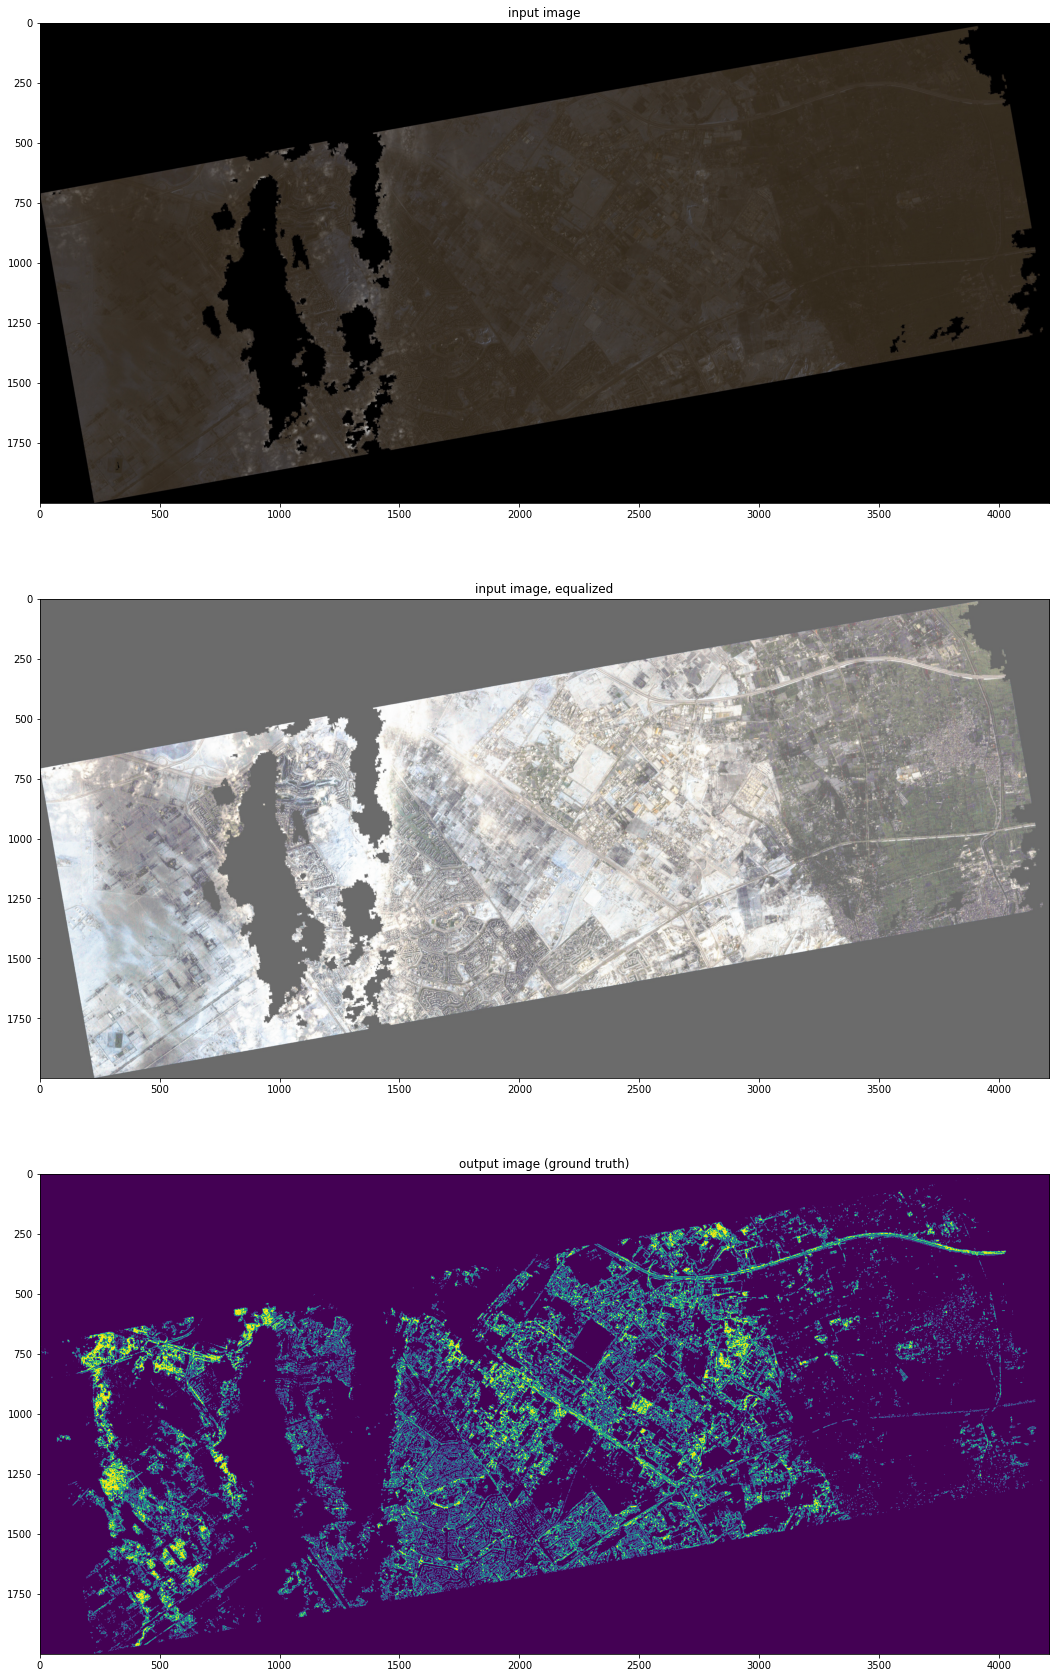

In [67]:
plt.figure(figsize = (30, 30)) 

plt.subplot(3,1,1) 
plt.imshow(clear_zayed) 
plt.title('input image')

plt.subplot(3,1,2)
plt.imshow(equalized_clear_zayed)
plt.title('input image, equalized');

plt.subplot(3,1,3)
plt.imshow(urban_mask[:,:,0])
plt.title('output image (ground truth)');

# Build model

In [68]:
K.clear_session()
seg = Segnet(nClasses = 1, input_height = 96, input_width = 96) 
seg.compile(optimizer = 'rmsprop', loss = 'sparse_categorical_crossentropy')



# Prepare data

### I specified the input size of the model to be (96, 96, 3). Thus a portion of that size will be cut from the large input image and the corresponding portion from the mask mask will be the ground truth of that input.

## The following two portions shows an example of an input portion and its correspoding output.

In [ ]:
z_portion, m_portion= get_portion(equalized_clear_zayed, urban_mask) 

plt.figure(figsize = (10, 5)) 

plt.subplot(1,2,1) 
plt.imshow(z_portion) 
plt.title('model input (96,96,3)   seeNotes*')

plt.subplot(1,2,2)
plt.imshow(m_portion[:,:,0])
plt.title('model output (96,96,1)');

 *Notes:


*   the picture above labeled as 'model input (96,96,3)' is the equalized input image not the input image iteself. I equalized it to be clearer, visually, but the input to the model should be the raw image because when the model is deployed, it will be fed the satellite images as is.



### Splitting data

available data shoud be splitted between training and validation data because deep learning model should be evaluated on the results they get on validation data not their results on training data.

This splitting has rules:


1.   splitting ratio should balance between keeping as much data to train on while having enough data to validate results. This is usually a 70/30 split between training/validation. 
2.   Both the training and the validation sets have to represent the data. This is very important. In our case, The large image we have show part of sheikh zayed city (which has a high living standard), an industrial area (contains unique shaped warehouses), and a high-density residential area. To make sure all these areas are represented in both sets, the large image is firstly splitted into strips, then strips are shuffled and assigned to one of the two sets depending on the splitting ratio


In [88]:
train_x, train_y, valid_x, valid_y = smart_split(clear_zayed, urban_mask, train_splitting_ratio = 0.7)
print("training data shape:{} | validation data shape:{}".format(train_x.shape, valid_x.shape))

training data shape:(600, 96, 96, 3) | validation data shape:(260, 96, 96, 3)


In [94]:
seed = 9 # (IMPORTANT) to transform image and corresponding mask with same augmentation parameter.
batch_size = 20 

datagen = ImageDataGenerator(rescale=1./255, rotation_range=40, width_shift_range=0.2, height_shift_range=0.2, 
                             shear_range=0.2, zoom_range=0.2, horizontal_flip=True, vertical_flip=True)
train_x_gen = datagen.flow(train_x, batch_size = batch_size, seed = seed)
train_y_gen = datagen.flow(train_y, batch_size = batch_size, seed = seed)
valid_x_gen = datagen.flow(valid_x, batch_size = batch_size, seed = seed)
valid_y_gen = datagen.flow(valid_y, batch_size = batch_size, seed = seed) 


train_gen = zip(train_x_gen, train_y_gen) 
valid_gen = zip(valid_x_gen, valid_y_gen) 



---

---

---







# Train

In [96]:
model_path = '/content/drive/MyDrive/satellite/zayed/model/urban_model.h5'
callbacks = [ ModelCheckpoint(model_path, save_best_only = True)]
EPOCHS = 30
training_steps = train_x.shape[0] // batch_size
validation_steps = valid_x.shape[0] // batch_size

history = seg.fit(train_gen, steps_per_epoch= training_steps, epochs = EPOCHS, validation_data = valid_gen, validation_steps= validation_steps, callbacks = callbacks)


Epoch 1/30


InvalidArgumentError: ignored